# Simulation of Hi-C data

In [1]:
import sys
sys.path.insert(1, '/home/elinfi/MasterCode/clustering/class/')

In [2]:
import time
import numpy as np
import cooltools.lib.plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

from time import time
from k_medoids import KMedoids
from cluster_statistics import ClusterStatistics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from data_preparation import DataPreparation
from dissimilarity_matrix import DissimilarityMatrix
from simulate_data import SimulateData

In [3]:
# globally set font sizes
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')

def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

In [5]:
resolution = 32000
region = 'chr4:5M-7M'

simulation = SimulateData(resolution, region)
print(np.sum(np.isnan(simulation.matrix)))
print(np.shape(simulation.matrix)[0] * np.shape(simulation.matrix)[1])

0
3969


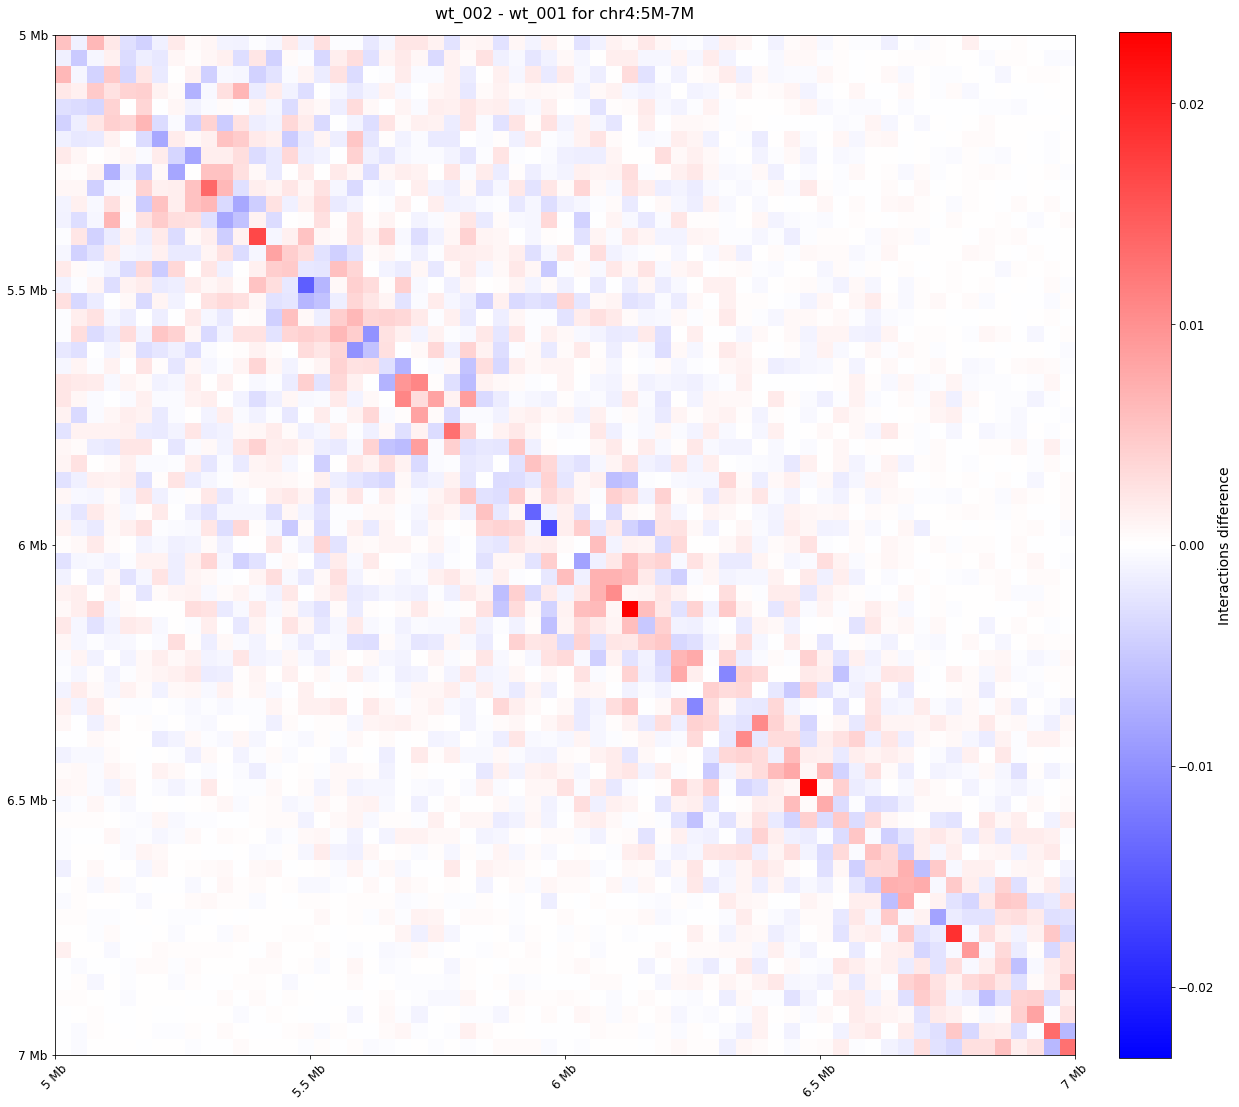

In [6]:
f, axs = plt.subplots(figsize=(20, 20),
                      nrows=1,
                      ncols=1,
                      sharex=True, sharey=False)
ax = axs
vmax = np.nanmax(abs(simulation.matrix))
im = ax.matshow(simulation.matrix,
                vmax=vmax,
                vmin=-vmax,
                cmap='bwr',
                extent=(5000000, 7000000, 7000000, 5000000))
                #extent=(0,simulation.clr.chromsizes[region], simulation.clr.chromsizes[region], 0))
plt.colorbar(im, fraction=0.046, pad=0.04, label='Interactions difference', ax=ax)
ax.set_title('wt_002 - wt_001 for ' + region, y=1.01)
#plt.savefig('../Figures/sub_002_001.png')
format_ticks(ax)

In [7]:
import cooler

def get_tad(region, resolution):
    filename = '/home/elinfi/coolers/HiC_wt_merged.mcool'
    clr = cooler.Cooler(filename
                        + '::resolutions/'
                        + str(resolution))
    matrix = clr.matrix(balance=True).fetch(region)
    return matrix

In [8]:
import pyranges as pr

maxSize=5000000

# bed-file containing TAD positions for wild type merged
filename = '/home/elinfi/storage/master_project/processed_data/tads/' \
                   + 'HiC_wt_merged_normalized_and_corrected_ice_domains.bed'

# read in the bed file with column names
df = pr.read_bed(filename, as_df=True)

# remove unecessary columns
df = df.drop(columns=['Score', 'Strand', 'ThickStart', 'ThickEnd', 'ItemRGB'])

# add new column containing TAD sizes
df['Size'] = df['End'] - df['Start']

# Sort table by TAD size
df = df.sort_values(['Size'])

# get random TAD below a given size
tad = df.loc[df['Size'] < maxSize].sample(n=1)

# create region
tad_region = tad['Chromosome'].values[0] + ':' + str(tad['Start'].values[0]) + '-' + str(tad['End'].values[0])


In [9]:
tad_matrix = get_tad(tad_region, resolution)

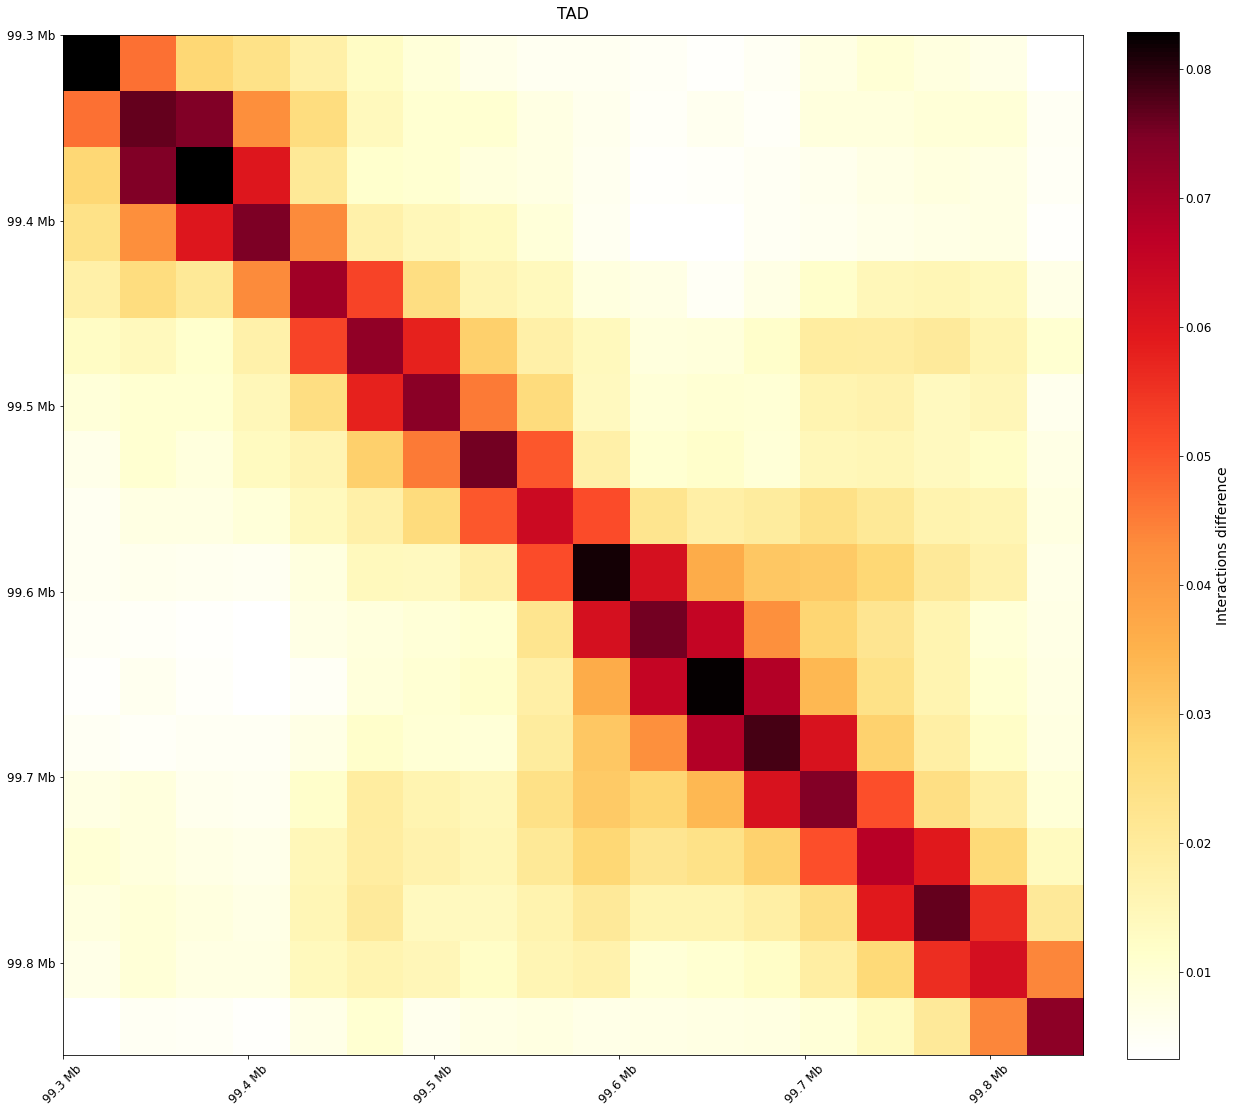

In [10]:
f, axs = plt.subplots(figsize=(20, 20),
                      nrows=1,
                      ncols=1,
                      sharex=True, sharey=False)
ax = axs
vmax = np.nanmax(abs(simulation.matrix))
im = ax.matshow(tad_matrix,
                cmap='fall',
                extent=(tad['Start'].values[0], tad['End'].values[0], tad['End'].values[0], tad['Start'].values[0]))
plt.colorbar(im, fraction=0.046, pad=0.04, label='Interactions difference', ax=ax)
ax.set_title('TAD', y=1.01)
#plt.savefig('../Figures/sub_002_001.png')
format_ticks(ax)

In [17]:
max_sim = simulation.matrix.shape[0]
max_tad = tad_matrix.shape[0]
max_idx = max_sim - max_tad

# random start index for TAD along the diagonal
start_idx = np.random.randint(low=0, high=max_idx + 1) # [low, high)
end_idx = start_idx + max_tad

new_sim = simulation.matrix.copy()
new_sim[start_idx:end_idx, start_idx:end_idx] = tad_matrix

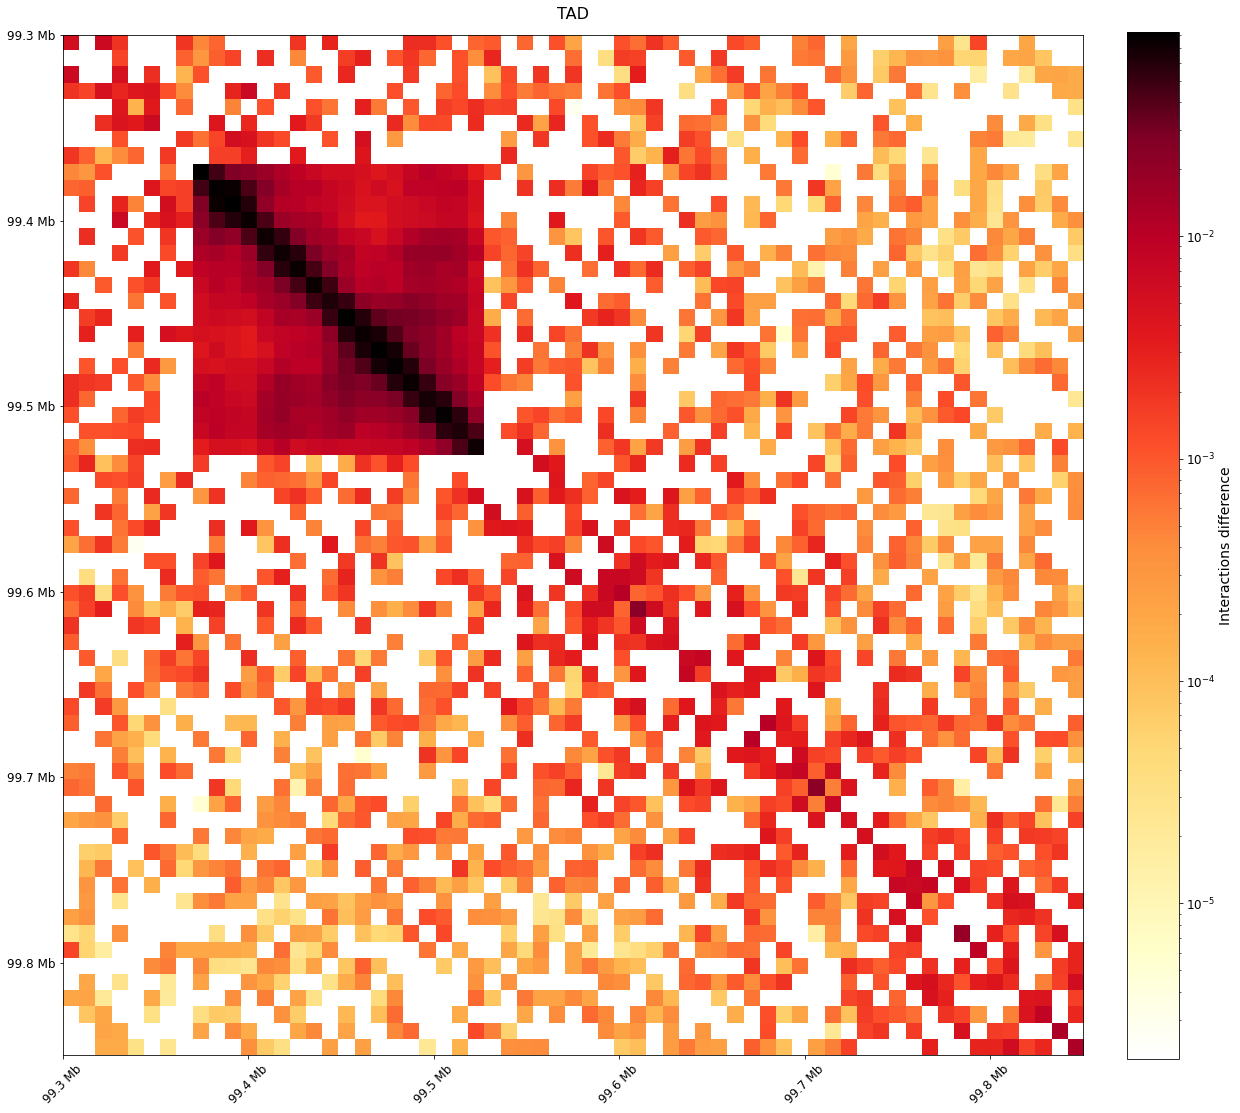

In [18]:
f, axs = plt.subplots(figsize=(20, 20),
                      nrows=1,
                      ncols=1,
                      sharex=True, sharey=False)
ax = axs
vmax = np.nanmax(abs(simulation.matrix))
norm = mpl.colors.LogNorm()
im = ax.matshow(new_sim,
                cmap='fall',
                norm=norm,
                extent=(tad['Start'].values[0], tad['End'].values[0], tad['End'].values[0], tad['Start'].values[0]))
plt.colorbar(im, fraction=0.046, pad=0.04, label='Interactions difference', ax=ax)
ax.set_title('TAD', y=1.01)
#plt.savefig('../Figures/sub_002_001.png')
format_ticks(ax)